In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.model_selection import train_test_split
import re
from multiprocessing import Pool
import nltk
import string
from nltk.tokenize import casual_tokenize,TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from functools import partial
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.pipeline import Pipeline as Pipeline_imb

In [3]:
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [5]:
import pickle
from wordcloud import WordCloud

In [6]:
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim import matutils
import pyLDAvis.gensim

In [7]:
pd.set_option('display.max_colwidth',-1)
% matplotlib inline
plt.style.use('seaborn-pastel')
pd.options.display.max_colwidth = -1
np.set_printoptions(3, suppress=True)

## Are 140 characters enough to identify their author? Machine learning, NLP: Text Classification using scikit-learn, python and NLTK.
### Task:
Identify the author of tweet accoring to analysis of tweets' content (with hashtags, urls and personal details cleaned). 


### Dataset from https://www.kaggle.com/speckledpingu/RawTwitterFeeds
### Description:
This is a dataset of **tweets** from various active **scientists** and **personalities** ranging from Donald Trump and Hillary Clinton to Neil deGrasse Tyson. The data was scraped using JavaScript directly off of Twitter's website and has been dumped from JSON into CSV using Pandas read_json and to_csv feature.


**Twitter** is an online news and **social networking service** on which users post and interact with messages known as "tweets". Tweets were originally restricted to 140 characters, but on November 7, 2017, this limit was doubled. 

### 1. Reading data

In [10]:
df = pd.read_csv('Data/famous_tweets/AllTweets.csv',usecols=['text','author','link'])

In [11]:
df.head(5)

,link,text,author
0,/NASA/status/787029214612586496,New software on the @Space_Station will make data communications faster and easier for hundreds of scientists: http://go.nasa.gov/2dQrLto pic.twitter.com/weIfEomT9x,NASA
1,/NASA/status/787008587927281664,READY for Launch! @OrbitalATK's #Antares rocket & cargo ship set to lift off at 8:03pm ET Sunday to @Space_Station: http://go.nasa.gov/2egj5e9 pic.twitter.com/pwB3mYIrrP,NASA
2,/NASA/status/787042156116664320,Rocket launch at 8:03pm ET Sunday to deliver cargo to @Space_Station. Are you in the launch viewing area? More: http://go.nasa.gov/2egB9Vw pic.twitter.com/eKMHk7eHRV,NASA
3,/NASA/status/787284414732472320,What happened this week at NASA? @POTUS outlined space exploration's future. Also highlighted: #WHFrontiers Conference & @NASA_Orion. Watch:pic.twitter.com/4UxeBWVhee,NASA
4,/NASA/status/786934496625102848,Energize! Study makes sure astronauts have energy they need. Watch our @Space_Station update. Q? Use #SpaceToGround. https://youtu.be/oKZvYztlpp4 pic.twitter.com/vo8HUB17Wm,NASA


### 2. Analysis of authors

In [12]:
df.shape

(88625, 3)

In [13]:
df.isnull().sum() # check null values

link      0
text      0
author    0
dtype: int64

In [14]:
df.author.value_counts()

DonaldTrump        17216
NASA               15910
KimKardashian      10688
various            10440
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
ScottKelly         1219 
Name: author, dtype: int64

### 2.1 What are "various" authors?

In [15]:
various_authors = [a[1] for a in df.loc[df.author == 'various','link'].str.split('/')]

In [16]:
df.loc[df.author == 'various','author'] = various_authors

In [17]:
author_stats = df.author.value_counts()

In [18]:
len(author_stats)# there are 2416 authors

2416

In [19]:
author_stats[:15]# we are taking into consideration authors with more than one thousand of tweets

DonaldTrump        17216
NASA               15910
KimKardashian      10688
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
kdnuggets          1572 
ScottKelly         1219 
datascigeek        667  
chi2innovations    364  
eelrekab           352  
innova_scape       237  
Name: author, dtype: int64

In [20]:
author_names = np.array(author_stats[author_stats > 1000].index)

In [21]:
df = df.loc[df.author.isin(author_names)]

In [22]:
df.author.value_counts()# check

DonaldTrump        17216
NASA               15910
KimKardashian      10688
FiveThirtyEight    9761 
BarackObama        6896 
RichardDawkins     5839 
AdamSavage         4872 
HillaryClinton     3356 
deGrasseTyson      2428 
kdnuggets          1572 
ScottKelly         1219 
Name: author, dtype: int64

In [23]:
print("Dataset contains {} tweets".format(df.shape[0]))

Dataset contains 79757 tweets


In [24]:
print("There are {} authors of more than one thousand tweets. ".format(len(author_names)))

There are 11 authors of more than one thousand tweets. 


### 2.2 Statistics for authors

In [25]:
author_counts = df.author.value_counts()
print(author_counts / author_counts.sum())

DonaldTrump        0.215856
NASA               0.199481
KimKardashian      0.134007
FiveThirtyEight    0.122384
BarackObama        0.086463
RichardDawkins     0.073210
AdamSavage         0.061086
HillaryClinton     0.042078
deGrasseTyson      0.030442
kdnuggets          0.019710
ScottKelly         0.015284
Name: author, dtype: float64


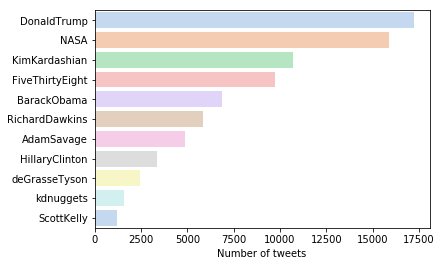

In [26]:
sns.barplot(x = author_counts.values,y = author_names,alpha = 0.7,orient="h",palette='pastel')
plt.xlabel('Number of tweets');

### Note: 
Inbalanced dataset with 11 authors and number of tweets ranging from 1.2 thousand up to 17.2 thousand.

### 2.3 Converting author's name to categorical variable

In [27]:
df.author = df.author.astype('category')

In [28]:
df.author.cat.categories

Index(['AdamSavage', 'BarackObama', 'DonaldTrump', 'FiveThirtyEight',
       'HillaryClinton', 'KimKardashian', 'NASA', 'RichardDawkins',
       'ScottKelly', 'deGrasseTyson', 'kdnuggets'],
      dtype='object')

### 2.4 Statistic for tweets

In [29]:
print('Tweets has on average {} signs.'.format(df.text.apply(lambda x: len(x)).mean()))

Tweets has on average 116.4430081372168 signs.


### 3. Splitting into train and test datasets

In [30]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.author,test_size = 0.2,
                                                 stratify = df.author,random_state = 123)

In [31]:
y_train.value_counts()

DonaldTrump        13773
NASA               12728
KimKardashian      8550 
FiveThirtyEight    7809 
BarackObama        5517 
RichardDawkins     4671 
AdamSavage         3897 
HillaryClinton     2685 
deGrasseTyson      1942 
kdnuggets          1258 
ScottKelly         975  
Name: author, dtype: int64

### 3. Preprocessing

### 3.1  Text cleaning - no hashtags, urls, pictures' links

Removing:
- "#" hashtags,
- "@" at sign,
- urls,
- pictures links


In [32]:
class TweetCleaner(TransformerMixin):
    '''
    removes urls, pictures,# hashtags,@ at signs from tweet
    return cleaned tweet, number of urls, pictures, # hastaags, @ at signs 
    '''
    
    def __init__(self,process=2):
        self.process = process 
        
    def cleaning_text(self,tweet):
        #urls
        regex = re.compile(r'http[s]*://[\w.\-/\\]+')
        url = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        #pictures
        regex = re.compile(r'pic.*')
        pic = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # '#'hashtags
        regex = re.compile(r'#\w+')
        hashtag = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # '@'at signs
        regex = re.compile(r'@\w+')
        at_sign = len(regex.findall(tweet))
        tweet = regex.sub('',tweet)

        # multiple whitespaces
        tweet = re.sub(r'\s{2,}','',tweet)

        return tweet,url,pic,hashtag,at_sign
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        pool = Pool(self.process)
        result = pool.map(self.cleaning_text,X)
        pool.close()
        pool.join()
        
        cleaned_tweets = [res[0] for res in result]
        urls = [res[1] for res in result]
        pics = [res[2] for res in result]
        hashtags = [res[3] for res in result]
        at_signs = [res[4] for res in result]
        
        X_out = pd.DataFrame({
            'text':cleaned_tweets,
            'urls':urls,
            'pics':pics,
            'hashtags':hashtags,
            'at_signs':at_signs
        })
        
        return X_out
    

In [33]:
cleaner = TweetCleaner(2)

In [34]:
X_cleaned = cleaner.fit_transform(X_train)

In [35]:
X_cleaned.head()

,text,urls,pics,hashtags,at_signs
0,I willbe releasing the full interview with a guy named Baxteronly to show the bias and stupidity of him and . Clowns!,0,0,0,2
1,Baby boomers use way more drugs than older generations did at their age:,1,1,0,0
2,Hillary Clinton got the biggest post-debate polling bounce:,1,1,0,0
3,Take a 360 video ride with our 10-propeller Greased Lightning plane! Start your flight:,1,1,0,0
4,We don't have a country- if we don't have borders.Video:…,1,1,1,0


### 3.3 Tokenization

In [36]:
class TweetProcessor(TransformerMixin):
    '''
    removes punctuation, stopwords, converts to stems 
    returns cleaned text, average length of words in tweet and number of words in tweet
    '''
    
    def __init__(self,stopwords,process=2):
        self.process = process
        self.stopwords = stopwords
       
    def processing_text(self,tweet,stopwords,stemmer):
        # remove cappital letters
        tweet = tweet.lower()

        # tokenizer for informal text
        tokens = casual_tokenize(tweet)

        # remove punctuation
        tokens_no_punct = [token for token in tokens if not token in string.punctuation]

        # number of words in tweet
        words_count = len(tokens_no_punct)

        # average length of words in tweet
        token_len = [len(token) for token in tokens_no_punct]
        if len(token_len) > 0 :
            aver_len = np.array(token_len).mean()
        else:
            aver_len = 0

        #remove stopwords
        tokens_no_stopwords = [token for token in tokens_no_punct if not token in stopwords]

        #stemming
        stems = [stemmer.stem(token) for token in tokens_no_stopwords]

        return ' '.join(stems),aver_len,words_count
    
    def add_stopwords(self,words):
        '''adds additional stopwords e.g. names, surnames'''
        
        for word in words:
            self.stopwords.append(word)

    def fit(self,X,y=None):
        # find text column
        self.key = X.select_dtypes(exclude='number').columns[0]
        return self
    
    def transform(self,X,y=None):
        
        X = X.copy()
        
        X_text = X.pop(self.key)
        
        porter_stemmer = PorterStemmer()
        
        pool = Pool(self.process)
        results = pool.map(partial(self.processing_text,stopwords=self.stopwords,stemmer=porter_stemmer),X_text)
        pool.close()
        pool.join()
        
        processed_tweets = [res[0] for res in results]
        tokens_length = [res[1] for res in results]
        words_count = [res[2] for res in results]
        
        X_out = pd.DataFrame({
            'text':processed_tweets,
            'tokens_length':tokens_length,
            'words_count':words_count,
        })
    
        return pd.concat([X,X_out],axis=1)

In [37]:
stopwords = nltk.corpus.stopwords.words('english')

In [38]:
add_words = ['nasa','adam','savage','barack','obama','donald','trump','hillary','clinton',
             'kim','kardashian','kardashians','de','grasse','tyson','scott','kelly','richard','dawkins',
             'adamsavage','barackobama','donaldtrump','hillaryclinton','kimkardashian','degrassetyson',
             'scottkelly','richarddawkins','fivethirtyeight','kdnuggets']

In [39]:
processor = TweetProcessor(nltk.corpus.stopwords.words('english'),2)

In [40]:
processor.add_stopwords(add_words)

In [41]:
X_proc = processor.fit_transform(X_cleaned)

In [42]:
X_proc.head()

,urls,pics,hashtags,at_signs,text,tokens_length,words_count
0,0,0,0,2,willb releas full interview guy name baxteronli show bia stupid clown,4.476190,21
1,1,1,0,0,babi boomer use way drug older gener age,4.538462,13
2,1,1,0,0,got biggest post-deb poll bounc,6.375000,8
3,1,1,0,0,take 360 video ride 10 propel greas lightn plane start flight,4.733333,15
4,1,1,1,0,countri borders.video …,4.181818,11


### 4. Classification
- To handle imbalanced dataset try three solutions: undersampling data, weighting classes according to samples size, oversampling data.
- To reduce time needed for tuning hyperparameters, first (except of oversampled dataset), optimize parameters for TF-IDF vectorizerin conjunction with Naive Bayes classifier, then, with vectorizer parameters set, check results for three different classifiers and tune their hyperparameters. 

In [43]:
class ItemSelector(BaseEstimator,TransformerMixin):
    '''
    return columns of certain type according to a given key
    '''
    def __init__(self,key):
        self.key = key
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        df = X.select_dtypes(include=self.key)
        if df.shape[1] == 1:
            #convert to series
            df = pd.Series(df.values.ravel())
        return df

In [44]:
class ArrayCaster(BaseEstimator,TransformerMixin):
    '''
    return data casted to numpy array
    '''
    def fit(self, X, y=None):
        return self

    def transform(self, X,y=None):
        return np.array(X)

### 4.1 Undersampled data

### 4.1.1 Optimize vectorizer parameters with use of NaiveBayes classifier

In [45]:
pipe = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('caster',ArrayCaster())
            ]))
        ]
    )),
    ('resampling',RandomUnderSampler()),
    ('bayes',MultinomialNB())
])

param_bayes = {
    'features__text__vectorizer__min_df':[10,20,50],
    'features__text__vectorizer__max_df':[0.2,0.3,0.5,0.7]
}

grid = GridSearchCV(estimator=pipe,
                   param_grid = param_bayes,
                   scoring='f1_micro',
                   n_jobs=2,
                   cv=KFold(5,shuffle=True))

grid.fit(X_proc,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('selector1', ItemSelector(key='object')), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...      return_indices=False)), ('bayes', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'features__text__vectorizer__min_df': [10, 20, 50], 'features__text__vectorizer__max_df': [0.2, 0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [46]:
grid.best_params_

{'features__text__vectorizer__max_df': 0.3,
 'features__text__vectorizer__min_df': 50}

In [47]:
# remember best parameters of vectorizer
max_df = grid.best_params_['features__text__vectorizer__max_df']
min_df = grid.best_params_['features__text__vectorizer__min_df']

In [48]:
grid.best_score_

0.579406002664368

### 4.1.2 Apply vectorizer parameters

In [49]:
pipe_under = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('scaler',MinMaxScaler())
            ]))
        ]
    )),
    ('resampling',RandomUnderSampler())#SMOTE(k_neighbors=3,m_neighbors=7))
])

X_res,y_res = pipe_under.fit_sample(X_proc,y_train)

In [50]:
X_res.shape

(10725, 1824)

In [51]:
y_res.shape

(10725,)

In [52]:
pd.Series(y_res).value_counts()

BarackObama        975
DonaldTrump        975
AdamSavage         975
KimKardashian      975
deGrasseTyson      975
RichardDawkins     975
ScottKelly         975
HillaryClinton     975
FiveThirtyEight    975
NASA               975
kdnuggets          975
dtype: int64

### 4.1.3 Find optimal classifier

In [53]:
names = ['NaiveBayes','LogistiRegression','SGDClassifier']

classificators = [
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(fit_intercept = True,max_iter = 100) 
]
param_bayes = {
    'alpha':[0.1,1.0]
}

param_logreg = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1.0,10.0],
    'multi_class':['ovr']
}

param_sgd = {
    #Linear SVC, logreg
    'loss':['hinge','log'],
    'penalty':['l1','l2'],
    'alpha':[0.0001,0.01,0.1,1.0]
}
params = [param_bayes,param_logreg,param_sgd]

In [54]:
for classificator,name,param in zip(classificators,names,params):
    print(name)
    
    grid = GridSearchCV(estimator=classificator,
                        param_grid = param,
                        scoring='f1_micro',
                        n_jobs=-1,
                        cv=KFold(5,shuffle=True),
                       )
        
    grid.fit(X_res,y_res)
    y_pred = grid.predict(X_res)
            
    print(grid.best_params_)
    print(grid.best_score_)
    print(classification_report(y_true=y_res,y_pred=y_pred))
    
    #saving model
    model_name = './Models/Undersampled' + name +'.p'
    with open(model_name,'wb') as f:
        pickle.dump(grid.best_estimator_,f)

NaiveBayes
{'alpha': 1.0}
0.6220979020979021
                 precision    recall  f1-score   support

     AdamSavage       0.66      0.62      0.64       975
    BarackObama       0.75      0.74      0.74       975
    DonaldTrump       0.79      0.71      0.75       975
FiveThirtyEight       0.77      0.78      0.77       975
 HillaryClinton       0.66      0.66      0.66       975
  KimKardashian       0.73      0.71      0.72       975
           NASA       0.79      0.86      0.82       975
 RichardDawkins       0.81      0.77      0.79       975
     ScottKelly       0.68      0.78      0.73       975
  deGrasseTyson       0.85      0.70      0.77       975
      kdnuggets       0.80      0.92      0.86       975

    avg / total       0.75      0.75      0.75     10725

LogistiRegression
{'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l2'}
0.6665734265734266
                 precision    recall  f1-score   support

     AdamSavage       0.75      0.59      0.66       975
    Barac

### 4.2 Weighted classes - weights according to classes' cardinality, the most numerous class - weight =  1.0 

### 4.2.1 Optimize vectorizer parameters with use of NaiveBayes classifier

In [55]:
max_count = y_train.value_counts().max()

In [56]:
weights_author = max_count / y_train.value_counts()

In [57]:
dict_weights = {key:value for key,value in zip(weights_author.index,weights_author.values)}# find weights for each class

In [58]:
weights = [dict_weights[y] for y in y_train]#copy weight for each sample

In [59]:
pipe = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('caster',MinMaxScaler())
            ]))
        ]
    )),
    ('resampling',RandomUnderSampler()),
    ('bayes',MultinomialNB())
])

param_bayes = {
    'features__text__vectorizer__min_df':[10,20,50],
    'features__text__vectorizer__max_df':[0.2,0.3,0.5,0.7]
}

grid = GridSearchCV(estimator=pipe,
                   param_grid = param_bayes,
                   scoring='f1_micro',
                   n_jobs=-1,
                   cv=KFold(5,shuffle=True))

grid.fit(X_proc,y_train,weights)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('text', Pipeline(memory=None,
     steps=[('selector1', ItemSelector(key='object')), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input=...      return_indices=False)), ('bayes', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'features__text__vectorizer__min_df': [10, 20, 50], 'features__text__vectorizer__max_df': [0.2, 0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [60]:
grid.best_params_

{'features__text__vectorizer__max_df': 0.3,
 'features__text__vectorizer__min_df': 10}

In [61]:
# remember best parameters of vectorizer
max_df = grid.best_params_['features__text__vectorizer__max_df']
min_df = grid.best_params_['features__text__vectorizer__min_df']

In [62]:
grid.best_score_

0.6582712953530288

### 4.2.2 Apply vectorizer parameters

In [63]:
pipe_weights = Pipeline([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('scaler',MinMaxScaler())
            ]))
        ]
    )),
])

X_proc2 = pipe_weights.fit_transform(X_proc)

In [64]:
X_proc2.shape

(63805, 5311)

In [65]:
X_proc.shape

(63805, 7)

In [66]:
y_train.shape

(63805,)

In [67]:
len(weights)

63805

### 4.2.3 Find optimal classifier

In [68]:
names = ['NaiveBayes','LogistiRegression','SGDClassifier']

classificators = [
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(fit_intercept = True,max_iter = 100) 
]
param_bayes = {
    'alpha':[0.1,1.0]
}

param_logreg = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1.0,10.0],
    'multi_class':['ovr']
}

param_sgd = {
    #Linear SVC, logreg
    'loss':['hinge','log'],
    'penalty':['l1','l2'],
    'alpha':[0.0001,0.01,0.1,1.0]
}
params = [param_bayes,param_logreg,param_sgd]

In [69]:
for classificator,name,param in zip(classificators,names,params):
    print(name)
    
    grid = GridSearchCV(estimator=classificator,
                        param_grid = param,
                        scoring='f1_micro',
                        n_jobs=2,
                        cv=KFold(5,shuffle=True),
                       )
        
    grid.fit(X_proc2,y_train,weights)
    y_pred = grid.predict(X_proc2)
            
    print(grid.best_params_)
    print(grid.best_score_)
    print(classification_report(y_true=y_train,y_pred=y_pred))
    
    #saving model
    model_name = './Models/Weighted' + name +'.p'
    with open(model_name,'wb') as f:
        pickle.dump(grid.best_estimator_,f)

NaiveBayes
{'alpha': 0.1}
0.7517279210093253
                 precision    recall  f1-score   support

     AdamSavage       0.79      0.56      0.65      3897
    BarackObama       0.78      0.73      0.75      5517
    DonaldTrump       0.75      0.91      0.82     13773
FiveThirtyEight       0.84      0.83      0.83      7809
 HillaryClinton       0.83      0.38      0.52      2685
  KimKardashian       0.80      0.83      0.81      8550
           NASA       0.82      0.95      0.88     12728
 RichardDawkins       0.88      0.81      0.84      4671
     ScottKelly       0.95      0.33      0.49       975
  deGrasseTyson       0.94      0.54      0.69      1942
      kdnuggets       0.97      0.63      0.77      1258

    avg / total       0.81      0.81      0.80     63805

LogistiRegression
{'C': 10.0, 'multi_class': 'ovr', 'penalty': 'l2'}
0.8077266671890918
                 precision    recall  f1-score   support

     AdamSavage       0.84      0.71      0.77      3897
    Bara

### 4.2 Oversampled data

### 4.2.1 Apply vectorizer parameters (apply optimal parameters obtained for weighted classes )

In [113]:
pipe = Pipeline_imb([
    ('features',FeatureUnion(
        transformer_list=[
            ('text',Pipeline([
                ('selector1',ItemSelector('object')),
                ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
            ])),
            ('numeric',Pipeline([
                ('selector2',ItemSelector('number')),
                ('scaler',MinMaxScaler())
            ]))
        ]
    )),
    ('resampling',SMOTE(k_neighbors=3,m_neighbors=7))
])

X_res,y_res = pipe.fit_sample(X_proc,y_train)

In [114]:
X_res.shape

(151503, 5311)

In [115]:
y_res.shape

(151503,)

### 4.3.2 Find optimal classifier

In [116]:
names = ['NaiveBayes','LogistiRegression','SGDClassifier']

classificators = [
    MultinomialNB(),
    LogisticRegression(),
    SGDClassifier(fit_intercept = True,max_iter = 100) 
]
param_bayes = {
    'alpha':[0.1]
}

param_logreg = {
    'penalty':['l1','l2'],
    'C':[0.01,0.1,1.0],
    'multi_class':['ovr']
}

param_sgd = {
    #Linear SVC, logreg
    'loss':['hinge','log'],
    'penalty':['l1','l2'],
    'alpha':[0.0001,0.01,0.1,1.0]
}
params = [param_bayes,param_logreg,param_sgd]

In [117]:
for classificator,name,param in zip(classificators,names,params):
    print(name)
    
    grid = GridSearchCV(estimator=classificator,
                        param_grid = param,
                        scoring='f1_micro',
                        n_jobs=-1,
                        cv=KFold(5,shuffle=True),
                       )
        
    grid.fit(X_res,y_res)
    y_pred = grid.predict(X_res)
            
    print(grid.best_params_)
    print(grid.best_score_)
    print(classification_report(y_true=y_res,y_pred=y_pred))
    
    #saving model
    model_name = './Models/Oversampled_' + name +'.p'
    with open(model_name,'wb') as f:
        pickle.dump(grid.best_estimator_,f)

NaiveBayes
{'alpha': 0.1}
0.790855626621255
                 precision    recall  f1-score   support

     AdamSavage       0.73      0.73      0.73     13773
    BarackObama       0.80      0.75      0.78     13773
    DonaldTrump       0.82      0.77      0.79     13773
FiveThirtyEight       0.82      0.80      0.81     13773
 HillaryClinton       0.73      0.73      0.73     13773
  KimKardashian       0.82      0.78      0.80     13773
           NASA       0.86      0.87      0.87     13773
 RichardDawkins       0.84      0.86      0.85     13773
     ScottKelly       0.77      0.87      0.82     13773
  deGrasseTyson       0.87      0.81      0.84     13773
      kdnuggets       0.87      0.96      0.91     13773

    avg / total       0.81      0.81      0.81    151503

LogistiRegression
{'C': 1.0, 'multi_class': 'ovr', 'penalty': 'l1'}
0.8170927308370132
                 precision    recall  f1-score   support

     AdamSavage       0.79      0.72      0.75     13773
    Barack

### 5. Best model - Logistic regresion with weighted classes (according to f1-micro)

In [71]:
model_name = './Models/WeightedLogistiRegression.p'
with open(model_name,'rb') as f:
    best_model = pickle.load(f)

In [72]:
y_pred = best_model.predict(X_proc2)
print(classification_report(y_true=y_train,y_pred=y_pred))

                 precision    recall  f1-score   support

     AdamSavage       0.84      0.71      0.77      3897
    BarackObama       0.86      0.86      0.86      5517
    DonaldTrump       0.88      0.94      0.91     13773
FiveThirtyEight       0.91      0.95      0.93      7809
 HillaryClinton       0.85      0.63      0.72      2685
  KimKardashian       0.86      0.91      0.89      8550
           NASA       0.94      0.97      0.95     12728
 RichardDawkins       0.92      0.90      0.91      4671
     ScottKelly       0.89      0.69      0.78       975
  deGrasseTyson       0.94      0.82      0.88      1942
      kdnuggets       0.96      0.93      0.94      1258

    avg / total       0.90      0.90      0.89     63805



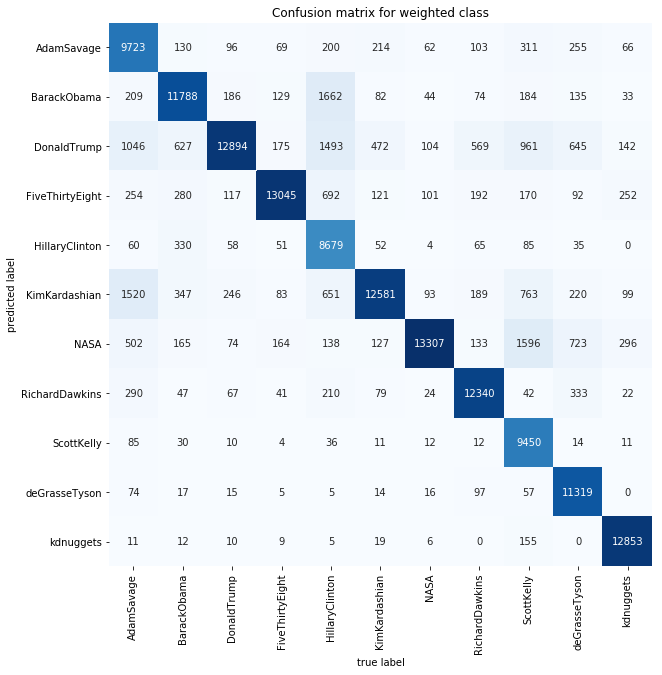

In [112]:
cm = confusion_matrix(y_true=y_train,y_pred=y_pred,sample_weight=weights)

plt.figure(figsize=(10,10))
sns.heatmap(cm.T,square=True,annot=True,fmt='.0f',cbar=False,cmap='Blues',
            xticklabels=df.author.cat.categories,yticklabels=df.author.cat.categories)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix for weighted class')
plt.show()

### 6. Model evaluation on test data

### 6.1 Initial processing of test data

In [74]:
X_cleaned_test = cleaner.transform(X_test)

In [75]:
X_proc_test = processor.transform(X_cleaned_test)

In [76]:
X_proc2_test = pipe_weights.transform(X_proc_test)

In [77]:
weights_test = [dict_weights[y] for y in y_test]

In [78]:
len(weights_test)

15952

In [79]:
X_proc2.shape

(63805, 5311)

### 6.2 Model evaluation

In [80]:
y_pred_test = best_model.predict(X_proc2_test)
print(classification_report(y_true=y_test,y_pred=y_pred_test))

                 precision    recall  f1-score   support

     AdamSavage       0.66      0.51      0.58       975
    BarackObama       0.75      0.75      0.75      1379
    DonaldTrump       0.81      0.89      0.85      3443
FiveThirtyEight       0.84      0.88      0.86      1952
 HillaryClinton       0.62      0.42      0.50       671
  KimKardashian       0.78      0.84      0.81      2138
           NASA       0.89      0.94      0.92      3182
 RichardDawkins       0.83      0.76      0.79      1168
     ScottKelly       0.69      0.44      0.53       244
  deGrasseTyson       0.78      0.60      0.68       486
      kdnuggets       0.91      0.83      0.87       314

    avg / total       0.80      0.81      0.80     15952



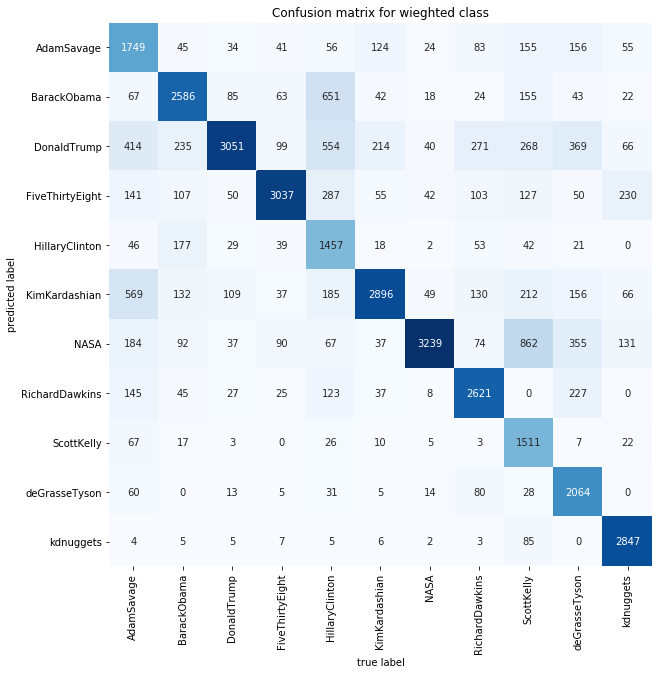

In [81]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred_test,sample_weight=weights_test)

plt.figure(figsize=(10,10))
sns.heatmap(cm.T,square=True,annot=True,fmt='.0f',cbar=False,cmap='Blues',
            xticklabels=df.author.cat.categories,yticklabels=df.author.cat.categories)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix for wieghted class')
plt.show()

### Note: 
- the lowest recall is obtained in case of classification of HilaryClinton's, ScottKelly's and AdamSavage's tweets, what means that there are a lot of false negative among them. According to the confusion matrix a remarkable set of HillaryClinton's tweets are confused with those authored by BarackObama and DonaldTrump (compare results of LDA analysis for HillaryClinton, BarackObama and DonaldTrump). Whereas many tweets of ScottKelly are wrongly classified as authored by NASA. The reason for that is because some of them have similiar topics(see LDA results) but also there are small number of tweets of this author (less than 1 thousand in train set). Also many tweets of AdamSavage are confused with KimKardashian's tweets(see LDA result)
- the highest precission is obtained for kdNuggets' tweets, as some of their topics are distinct from the others (see LDA results). 

### 7. Wrongly classified tweets

In [82]:
y_test = y_test.reset_index()
y_test.drop('index',axis=1,inplace=True)
X_test = X_test.reset_index()
X_test.drop('index',axis=1,inplace=True)

In [83]:
df_res = pd.concat([X_test,y_test],axis=1)

In [84]:
df_res['author_pred'] = y_pred_test

In [85]:
df_res.loc[(df_res['author'] != df_res['author_pred'])].head(20)

,text,author,author_pred
0,This is AMAZING:https://vimeo.com/157937153,AdamSavage,KimKardashian
1,@karimnanavour He has every right to express whatever he wants. And I have every right not to waste my time reading it.,RichardDawkins,DonaldTrump
4,"So, so good.http://youtu.be/PZbqAMEwtOE",AdamSavage,KimKardashian
8,Would seem that plane landed short of runway in San Francisco!,DonaldTrump,AdamSavage
20,"The loss of lives to terrorism is tragic and abhorrent, in Nigeria as in Europe. We must all come together to end this scourge. -H",HillaryClinton,DonaldTrump
22,Paleoclimate data show the 'dangerous' level of global warming is less than we thought: Hansen @theAGU. http://go.nasa.gov/u03v8h #agu11,NASA,DonaldTrump
32,"Hey everyone attending tonigh at the Swedish American in SF! Let's make @w00tstock a trending topic. 3,2,1...GO!",AdamSavage,KimKardashian
37,Departing for #GOPDebate. Let's #MakeAmericaGreatAgain! https://www.facebook.com/DonaldTrump/posts/10156417157260725:0 …pic.twitter.com/Bwyu1U3rHU,DonaldTrump,FiveThirtyEight
56,"""I will keep doing what I’ve done my entire life. I will keep standing up for you. I will keep fighting for you."" —Hillary",HillaryClinton,KimKardashian
66,"""I want to talk about what working families are up against."" Hillary’s remarks tonight after winning in Mississippi.https://amp.twimg.com/v/2e5b2cc9-dae9-4ba6-b9ed-8b630ad3c176 …",HillaryClinton,FiveThirtyEight


## What they are writing about? Machine learning, NLP: Topic modeling with Latent Dirichlet Allocation using python and Gensim

### Task:
Analyse the content of tweets, extract the most frequent topics for each author.  

### 1. The most frequent words for each author - Word Clouds

In [86]:
def most_frequent_words(X,k):
    '''
    return k terms which apear most often in dataset
    '''
    pipe_tf = Pipeline([
    ('selector1',ItemSelector('object')),
    ('vectorizer',TfidfVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
    ])
    X_proc_tf = pipe_tf.fit_transform(X)
    
    dtm_sum = np.array(X_proc_tf.sum(axis=0))[0]
    
    words_counter = np.argsort(dtm_sum)
    words_counter = words_counter[::-1]
        
    top_words_indices = words_counter[:k]
    words = np.array(pipe_tf.named_steps['vectorizer'].get_feature_names())
    return words[top_words_indices]

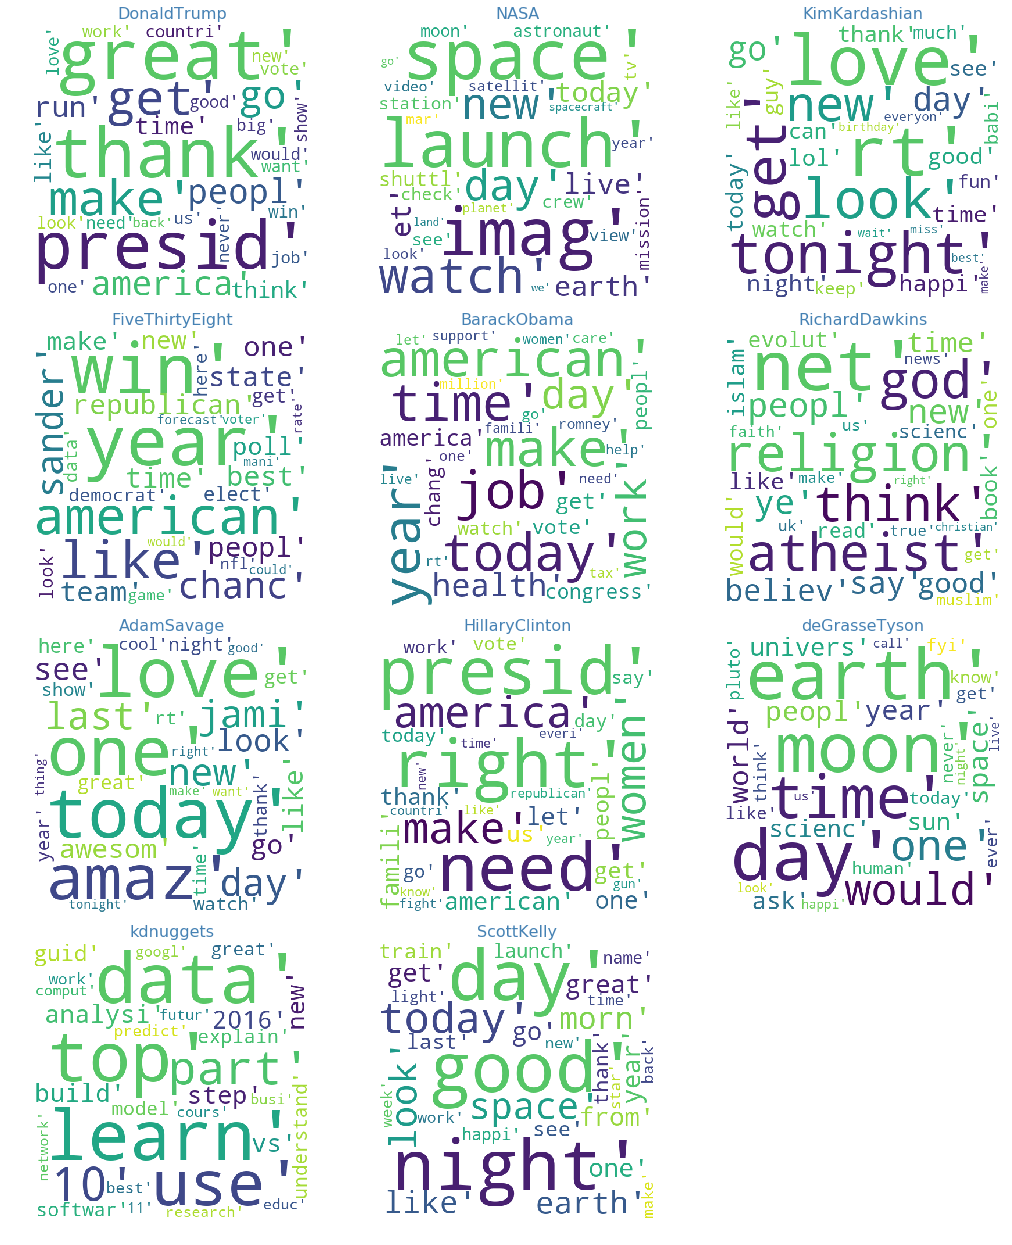

In [87]:
k = 30# number of words per cloud
plt.figure(figsize=(18,22))
plt.subplots_adjust(wspace = 0.1,hspace=0.1)

for i,name in enumerate(author_names):
    X_proc_author = X_proc[y_train.reset_index().drop('index',axis=1).author == name]
    
    wordcloud = WordCloud(
        width=480, 
        height=480,
        background_color='white',
        max_words=80,
        max_font_size=120, 
        random_state=42,
        scale = 1
    ).generate(str(most_frequent_words(X_proc_author,k)))
    
    ax= plt.subplot(4,3 ,i+1)
    plt.title(name,fontsize=16,color='steelblue')
    plt.imshow(wordcloud)
    plt.axis('off')

## 2. LDA - Latent Dirichlet Allocation

### 2.1 Text vectorizing

In [88]:
pipe = Pipeline([
    ('selector1',ItemSelector('object')),
    ('vectorizer',CountVectorizer(min_df=min_df,max_df=max_df,stop_words=add_words))
])

dtm = pipe.fit_transform(X_proc)

In [89]:
dtm

<63805x5305 sparse matrix of type '<class 'numpy.int64'>'
	with 472541 stored elements in Compressed Sparse Row format>

### 2.2 Create corpuse from sparse matrix

In [90]:
corpus = matutils.Sparse2Corpus(dtm,documents_columns=False)# by default documents in columns

In [91]:
len(corpus)

63805

In [92]:
vectorizer = pipe.named_steps['vectorizer']

In [93]:
dictionary = vectorizer.get_feature_names()

In [94]:
len(dictionary)

5305

In [95]:
dictionary_dict = {i:j for i,j in enumerate(dictionary)}

In [96]:
dictionary = corpora.Dictionary.from_corpus(corpus=corpus,id2word=dictionary_dict)

### 2.3 Build LDA model

In [97]:
top_nmb = 20 # number of topics (not very big to visualize the results)

In [98]:
lda_model = LdaModel(corpus=corpus,id2word=dictionary,num_topics=top_nmb,alpha='auto',eta='auto')

In [99]:
lda_model.alpha # alpha auto

array([0.075, 0.084, 0.087, 0.082, 0.085, 0.081, 0.073, 0.079, 0.081,
       0.086, 0.088, 0.076, 0.082, 0.097, 0.085, 0.074, 0.122, 0.078,
       0.072, 0.098], dtype=float32)

In [100]:
lda_model.eta

array([0.046, 0.126, 0.024, ..., 0.033, 0.033, 0.021], dtype=float32)

### 2.4 Calculate mean of topic coefficients for each author 

In [101]:
y_train_df = pd.DataFrame(y_train.reset_index().drop('index',axis=1))
author_topics = []
for i,name in enumerate(author_names):
    indexes = np.array(y_train_df.loc[y_train_df.author == name].index)
    
    topics_values = np.array([
        [topic_value[1] for topic_value in lda_model.get_document_topics(corpus[index],minimum_probability=0)]
        for index in indexes])
    
    author_topics.append(topics_values.mean(axis=0))                          

### 2.5 The most popular topics for each author

In [102]:
k=8 # number of topics
k_topics = []
for i,name in enumerate(author_names):
    print(name)
    k_topics.append(np.argsort(author_topics[i])[::-1][:k])
    print(k_topics[i])

DonaldTrump
[16 13 19  1 10  2 12  9]
NASA
[ 0  3 14  4  8  6 17 18]
KimKardashian
[10 13  2 16  5 12  4  1]
FiveThirtyEight
[16 19  8 13  1  4  5  9]
BarackObama
[16 19 13 17 11  3  9 10]
RichardDawkins
[ 9 16 17 13 19 12  2  5]
AdamSavage
[13  2 10 16  5 12  7  1]
HillaryClinton
[16 19 13  2  1 12 11  9]
deGrasseTyson
[14 13 18  9 16 19 12 10]
kdnuggets
[14 16 17 15  5 13  3  9]
ScottKelly
[13  4 16 14  1 10  3  0]


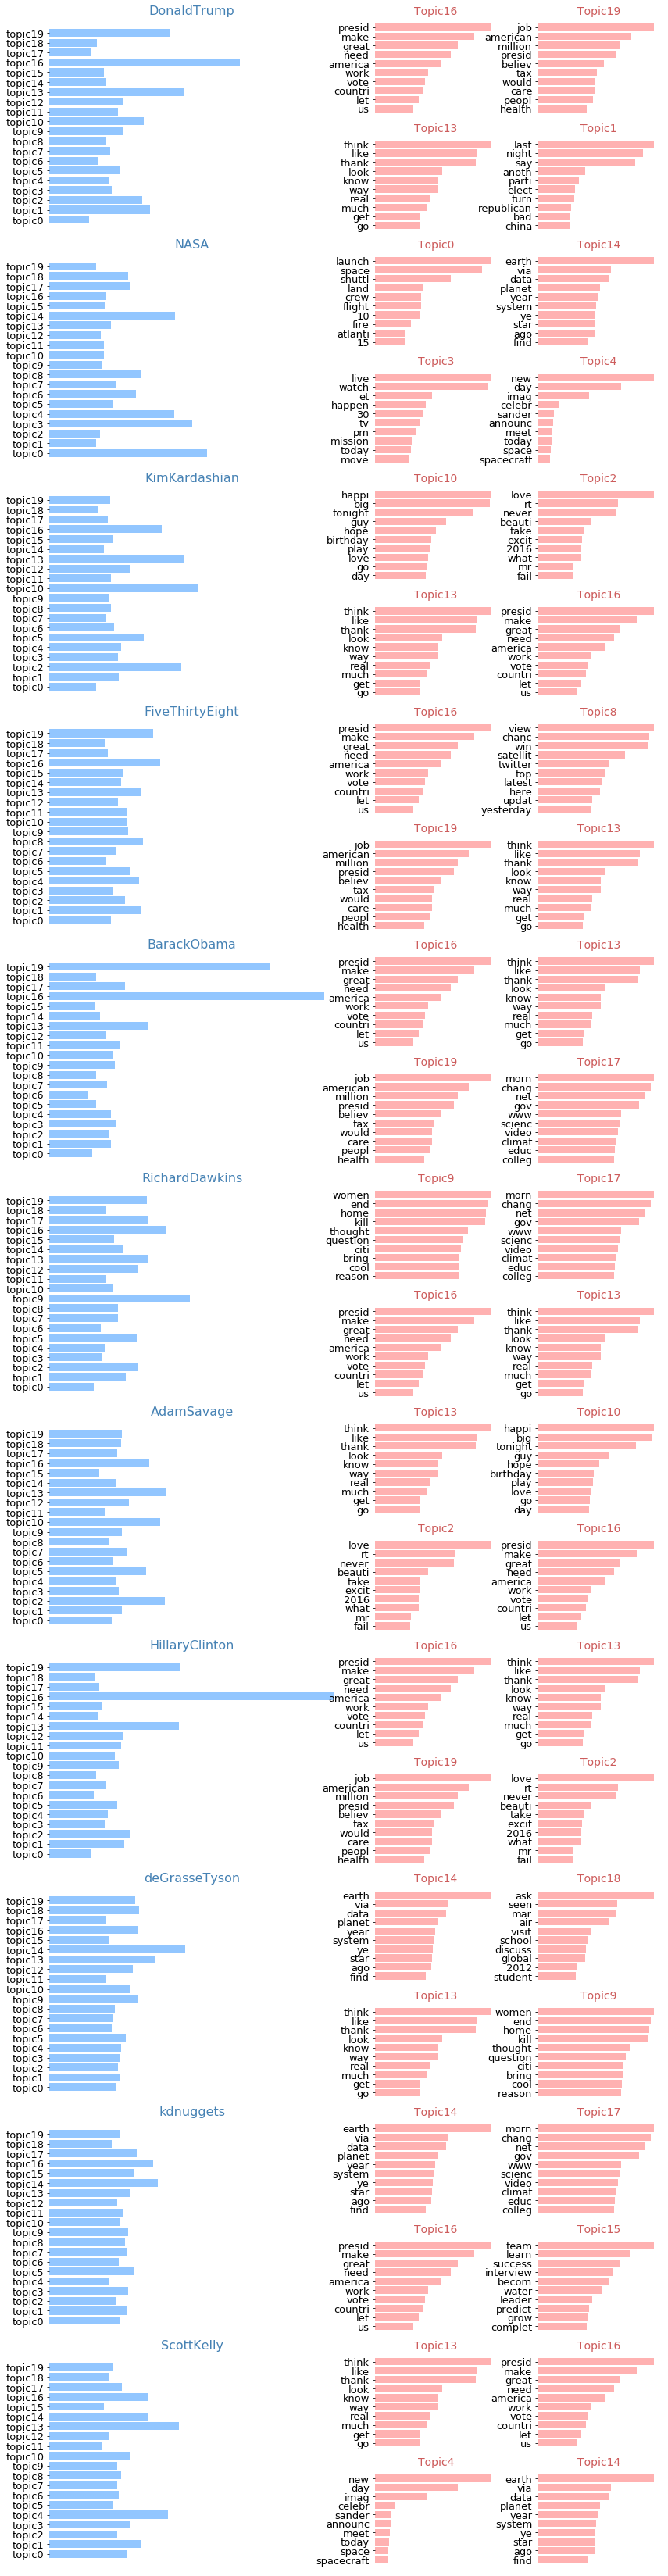

In [103]:
max_ = np.max(author_topics)

fig = plt.figure(figsize=(14,60))
grid = plt.GridSpec(4*len(author_names),8,hspace = 0.5,wspace=1.0)

y_min = 0
y_max = 0

for ind,name in enumerate(author_names):
    y_min = y_max 
    y_max = (ind + 1) * 4

    y_max_2 = y_min + 2
    
    
    main_ax = fig.add_subplot(grid[y_min:y_max,:4])
    top1 = fig.add_subplot(grid[y_min:y_max_2,4:6])
    top2 = fig.add_subplot(grid[y_max_2:y_max,4:6])
    top3 = fig.add_subplot(grid[y_min:y_max_2,6:])
    top4 = fig.add_subplot(grid[y_max_2:y_max,6:])
    
    main_ax.barh(['topic{}'.format(i) for i in range(0,top_nmb)],author_topics[ind])
    main_ax.set_title(name,fontsize=16,color='steelblue')
    main_ax.set_xlim(0,max_)
    main_ax.set_frame_on(False)
    main_ax.xaxis.set_visible(False)
    main_ax.tick_params(axis='y',labelsize = 13)
    
    topic_1 = k_topics[ind][0]
    topic_2 = k_topics[ind][1]
    topic_3 = k_topics[ind][2]
    topic_4 = k_topics[ind][3]
    
    word_value1 = [(dictionary[term_value[0]],term_value[1]) for term_value in lda_model.get_topic_terms(topic_1,topn=10)]
    word_value2 = [(dictionary[term_value[0]],term_value[1]) for term_value in lda_model.get_topic_terms(topic_2,topn=10)]
    word_value3 = [(dictionary[term_value[0]],term_value[1]) for term_value in lda_model.get_topic_terms(topic_3,topn=10)]
    word_value4 = [(dictionary[term_value[0]],term_value[1]) for term_value in lda_model.get_topic_terms(topic_4,topn=10)]
        
    top1.barh([word[0] for word in word_value1[::-1]],[value[1] for value in word_value1[::-1]],color='red',alpha=0.3)
    top2.barh([word[0] for word in word_value2[::-1]],[value[1] for value in word_value2[::-1]],color='red',alpha=0.3)
    top3.barh([word[0] for word in word_value3[::-1]],[value[1] for value in word_value3[::-1]],color='red',alpha=0.3)
    top4.barh([word[0] for word in word_value4[::-1]],[value[1] for value in word_value4[::-1]],color='red',alpha=0.3)
    
    top1.tick_params(axis='y',labelsize = 13)
    top2.tick_params(axis='y',labelsize = 13)
    top3.tick_params(axis='y',labelsize = 13)
    top4.tick_params(axis='y',labelsize = 13)
    
    top1.set_title('Topic{}'.format(topic_1),fontsize=14,color='indianred')
    top2.set_title('Topic{}'.format(topic_2),fontsize=14,color='indianred')
    top3.set_title('Topic{}'.format(topic_3),fontsize=14,color='indianred')
    top4.set_title('Topic{}'.format(topic_4),fontsize=14,color='indianred')

    top1.set_frame_on(False)
    top2.set_frame_on(False)
    top3.set_frame_on(False)
    top4.set_frame_on(False)
    
    top1.xaxis.set_visible(False)
    top2.xaxis.set_visible(False)
    top3.xaxis.set_visible(False)
    top4.xaxis.set_visible(False)

### 2.5 All topics aligned from the most to the least frequent in all tweets

In [104]:
pyLDAvis.enable_notebook()

In [109]:
# topics are sorted from most to least popular! the order of topics is changed
prepared = pyLDAvis.gensim.prepare(lda_model,corpus=corpus,dictionary=dictionary)

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [110]:
pyLDAvis.save_html(prepared,'./vis.html')# visualisation of all topics is saved in html format